In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [26]:
import numpy as np
import open3d as o3d
import torch
from skimage import measure
from tqdm import tqdm, trange

from core.dataset import ScanNet
from core.integrate import PanopticFusionScalableTSDFVolume, FeatureFusionScalableTSDFVolume

In [3]:
tsdf_device = 'cuda:1'
tsdf_volume = PanopticFusionScalableTSDFVolume(
    voxel_size=0.015,
    sdf_trunc=0.075,
    margin=0.08,
    device=tsdf_device,
)

save_dir = '/home/quanta/Experiments/feature-instance-fusion/scannet_scene0000_00/'
tsdf_volume.load(save_dir + 'tsdf/tsdf_vol.pt')

In [28]:
color_volume = FeatureFusionScalableTSDFVolume(
    voxel_size=0.015,
    sdf_trunc=0.075,
    margin=0.08,
    device=tsdf_device,
)
color_volume.load(save_dir + 'tsdf/tsdf_vol.pt')
color_volume.load_feats(save_dir + 'color/color_feats.pt')

In [4]:
tsdf_volume.set_mc_layer_mesh()

In [5]:
dataset = ScanNet('/home/quanta/Datasets/ScanNet/')
scan_id = 'scene0000_00'
id = dataset.scan_id_list.index(scan_id)
inst = dataset[id]
single_instance = inst['scan_dataset']
H, W = inst['color_height'], inst['color_width']

In [6]:
idx = 1
inputs = single_instance.get_torch_tensor(
    idx,
    device=tsdf_device,
    keys={
        "depth",
        "depth_intr",
        "pose",
        "color_intr",
        "color",
    },
)

In [7]:
import matplotlib.pyplot as plt

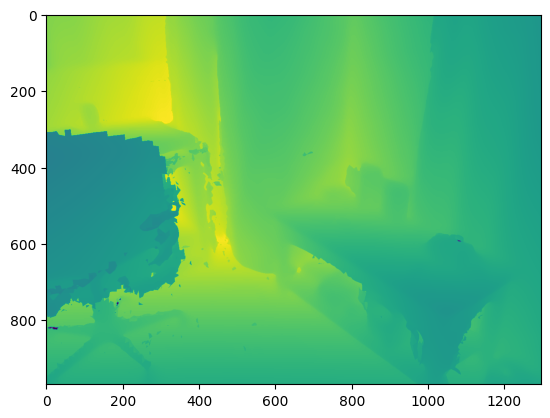

In [8]:
plt.imshow(
    tsdf_volume.get_depth_from_mc_mesh(
        cam_intr=inputs["color_intr"],
        cam_pose=inputs["pose"],
        H=H,
        W=W,
    )
)

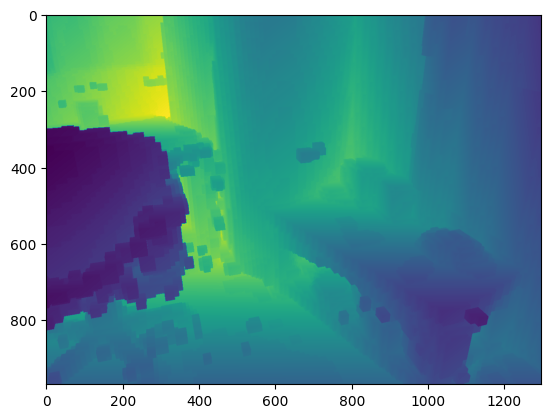

In [9]:
plt.imshow(
    tsdf_volume.get_depth_from_mc_voxel(
        cam_intr=inputs["color_intr"],
        cam_pose=inputs["pose"],
        H=H,
        W=W,
    )
)

In [10]:
from core.integrate.utils.tsdf_ops import pixel_voxel_corres_given_depth

0.7563952339047036


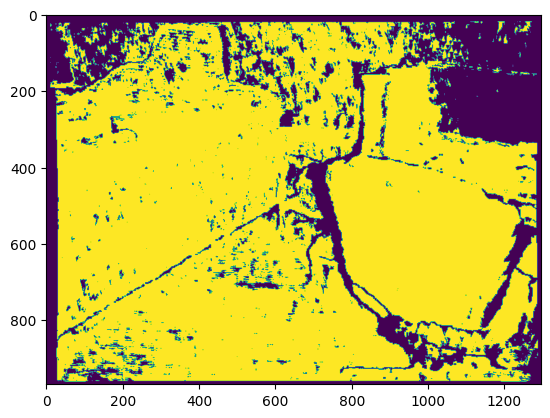

In [11]:
idx = 505
inputs = single_instance.get_torch_tensor(
    idx,
    device=tsdf_device,
    keys={
        "depth",
        "depth_intr",
        "pose",
        "color_intr",
        "color",
    },
)

depth = inputs["depth"]
# depth = torch.from_numpy(
#     tsdf_volume.get_depth_from_mc_voxel(
#         cam_intr=inputs["color_intr"],
#         cam_pose=inputs["pose"],
#         H=H,
#         W=W,
#     )
# ).to(inputs["depth"])
# depth[depth > 0] += tsdf_volume.voxel_size*0.01  # rounding is an issue!
# depth = torch.from_numpy(
#     tsdf_volume.get_depth_from_mc_mesh(
#         cam_intr=inputs["color_intr"],
#         cam_pose=inputs["pose"],
#         H=H,
#         W=W,
#     )
# ).to(inputs["depth"])
# depth[depth > 0] += tsdf_volume.voxel_size*0.01  # rounding is an issue!

px, py, corres = pixel_voxel_corres_given_depth(
    voxel_hash=tsdf_volume._voxel_hash,
    voxel_origin=tsdf_volume._vol_origin,
    voxel_size=tsdf_volume._voxel_size,
    cam_intr=inputs["color_intr"],
    cam_pose=inputs["pose"],
    H=H,
    W=W,
    depth=depth,
)

print(px.shape[0] / (H * W))

img = np.zeros((H, W))
img[py.cpu().numpy(), px.cpu().numpy()] = 1

plt.imshow(img)

corres_img = np.zeros((H, W))
corres_img[py.cpu().numpy(), px.cpu().numpy()] = corres.cpu().numpy()
corres_img1 = corres_img

0.6464925454035303


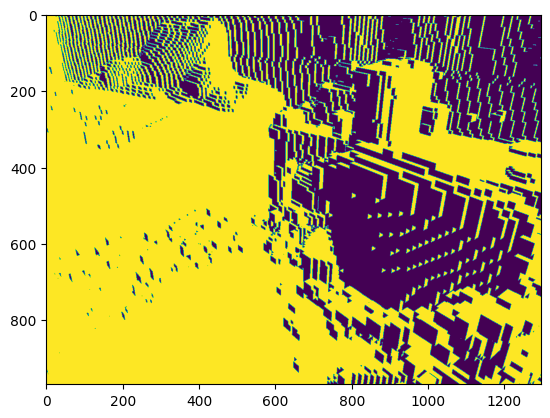

In [12]:
# depth = inputs["depth"]
depth = torch.from_numpy(
    tsdf_volume.get_depth_from_mc_voxel(
        cam_intr=inputs["color_intr"],
        cam_pose=inputs["pose"],
        H=H,
        W=W,
    )
).to(inputs["depth"])
# depth[depth > 0] += tsdf_volume.voxel_size*0.01  # rounding is an issue!
# depth = torch.from_numpy(
#     tsdf_volume.get_depth_from_mc_mesh(
#         cam_intr=inputs["color_intr"],
#         cam_pose=inputs["pose"],
#         H=H,
#         W=W,
#     )
# ).to(inputs["depth"])
# depth[depth > 0] += tsdf_volume.voxel_size*0.01  # rounding is an issue!

px, py, corres = pixel_voxel_corres_given_depth(
    voxel_hash=tsdf_volume._voxel_hash,
    voxel_origin=tsdf_volume._vol_origin,
    voxel_size=tsdf_volume._voxel_size,
    cam_intr=inputs["color_intr"],
    cam_pose=inputs["pose"],
    H=H,
    W=W,
    depth=depth,
)

print(px.shape[0] / (H * W))

img = np.zeros((H, W))
img[py.cpu().numpy(), px.cpu().numpy()] = 1

plt.imshow(img)

corres_img = np.zeros((H, W))
corres_img[py.cpu().numpy(), px.cpu().numpy()] = corres.cpu().numpy()
corres_img2 = corres_img

0.9985628060912152


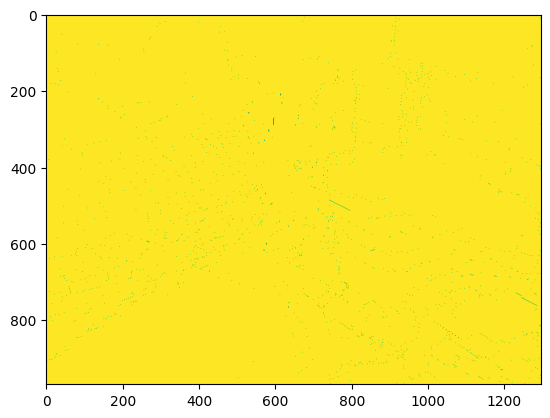

In [13]:
# depth = inputs["depth"]
depth = torch.from_numpy(
    tsdf_volume.get_depth_from_mc_voxel(
        cam_intr=inputs["color_intr"],
        cam_pose=inputs["pose"],
        H=H,
        W=W,
    )
).to(inputs["depth"])
depth[depth > 0] += tsdf_volume.voxel_size*0.01  # rounding is an issue!
# depth = torch.from_numpy(
#     tsdf_volume.get_depth_from_mc_mesh(
#         cam_intr=inputs["color_intr"],
#         cam_pose=inputs["pose"],
#         H=H,
#         W=W,
#     )
# ).to(inputs["depth"])
# depth[depth > 0] += tsdf_volume.voxel_size*0.01  # rounding is an issue!

px, py, corres = pixel_voxel_corres_given_depth(
    voxel_hash=tsdf_volume._voxel_hash,
    voxel_origin=tsdf_volume._vol_origin,
    voxel_size=tsdf_volume._voxel_size,
    cam_intr=inputs["color_intr"],
    cam_pose=inputs["pose"],
    H=H,
    W=W,
    depth=depth,
)

print(px.shape[0] / (H * W))

img = np.zeros((H, W))
img[py.cpu().numpy(), px.cpu().numpy()] = 1

plt.imshow(img)
corres_img = np.zeros((H, W))
corres_img[py.cpu().numpy(), px.cpu().numpy()] = corres.cpu().numpy()
corres_img3 = corres_img

0.9995727476788083


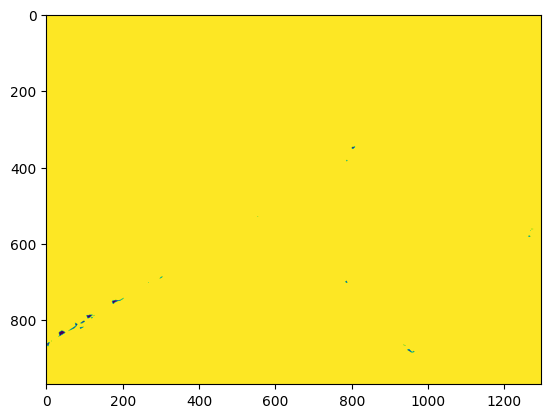

In [14]:
# depth = inputs["depth"]
# depth = torch.from_numpy(
#     tsdf_volume.get_depth_from_mc_voxel(
#         cam_intr=inputs["color_intr"],
#         cam_pose=inputs["pose"],
#         H=H,
#         W=W,
#     )
# ).to(inputs["depth"])
# depth[depth > 0] += tsdf_volume.voxel_size*0.01  # rounding is an issue!
depth = torch.from_numpy(
    tsdf_volume.get_depth_from_mc_mesh(
        cam_intr=inputs["color_intr"],
        cam_pose=inputs["pose"],
        H=H,
        W=W,
    )
).to(inputs["depth"])
# depth[depth > 0] += tsdf_volume.voxel_size*0.01  # rounding is an issue!

px, py, corres = pixel_voxel_corres_given_depth(
    voxel_hash=tsdf_volume._voxel_hash,
    voxel_origin=tsdf_volume._vol_origin,
    voxel_size=tsdf_volume._voxel_size,
    cam_intr=inputs["color_intr"],
    cam_pose=inputs["pose"],
    H=H,
    W=W,
    depth=depth,
)

print(px.shape[0] / (H * W))

img = np.zeros((H, W))
img[py.cpu().numpy(), px.cpu().numpy()] = 1

plt.imshow(img)

corres_img = np.zeros((H, W))
corres_img[py.cpu().numpy(), px.cpu().numpy()] = corres.cpu().numpy()
corres_img4 = corres_img

In [15]:
# original methods using real depth gives about 78% pixels corres
# using voxel's mesh gives 97% corres
# using marching cube mesh gives 99.98% pixels corres

In [16]:
%%time
px, py, corres = pixel_voxel_corres_given_depth(
    voxel_hash=tsdf_volume._voxel_hash,
    voxel_origin=tsdf_volume._vol_origin,
    voxel_size=tsdf_volume._voxel_size,
    cam_intr=inputs["color_intr"],
    cam_pose=inputs["pose"],
    H=H,
    W=W,
    depth=depth,
)

CPU times: user 11.5 ms, sys: 6.22 ms, total: 17.7 ms
Wall time: 5.86 ms


In [25]:
(corres_img1 == corres_img4).mean()

0.23500312468115497

0.9995727476788083


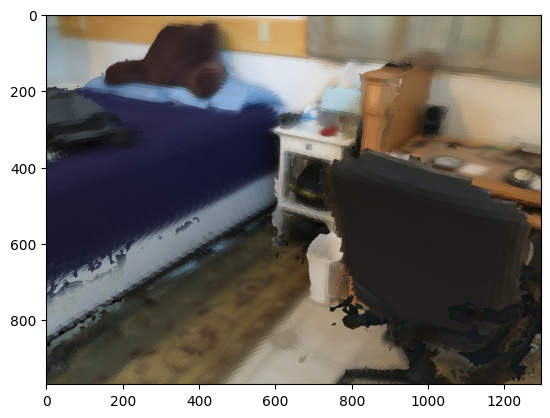

In [34]:
# depth = inputs["depth"]
# depth = torch.from_numpy(
#     tsdf_volume.get_depth_from_mc_voxel(
#         cam_intr=inputs["color_intr"],
#         cam_pose=inputs["pose"],
#         H=H,
#         W=W,
#     )
# ).to(inputs["depth"])
# depth[depth > 0] += tsdf_volume.voxel_size*0.01  # rounding is an issue!
depth = torch.from_numpy(
    tsdf_volume.get_depth_from_mc_mesh(
        cam_intr=inputs["color_intr"],
        cam_pose=inputs["pose"],
        H=H,
        W=W,
    )
).to(inputs["depth"])
# depth[depth > 0] += tsdf_volume.voxel_size*0.01  # rounding is an issue!

px, py, corres = pixel_voxel_corres_given_depth(
    voxel_hash=tsdf_volume._voxel_hash,
    voxel_origin=tsdf_volume._vol_origin,
    voxel_size=tsdf_volume._voxel_size,
    cam_intr=inputs["color_intr"],
    cam_pose=inputs["pose"],
    H=H,
    W=W,
    depth=depth,
)

print(px.shape[0] / (H * W))

img = np.zeros((H, W, 3)).astype(float)
img[py.cpu().numpy(), px.cpu().numpy()] = color_volume._feat[corres].cpu().numpy()

plt.imshow(img)

# corres_img = np.zeros((H, W))
# corres_img[py.cpu().numpy(), px.cpu().numpy()] = corres.cpu().numpy()
# corres_img4 = corres_img

In [35]:
a = 1

In [36]:
b = a

In [37]:
a += 1

In [38]:
a

2

In [39]:
b

1

In [41]:
a = torch.randint(3, 59, (45, ))

In [45]:
a.gather(0, a.argsort())

tensor([ 3,  4,  7,  8, 10, 12, 12, 13, 13, 14, 15, 15, 15, 16, 19, 20, 24, 24,
        25, 25, 26, 26, 26, 26, 27, 28, 30, 30, 31, 32, 34, 34, 38, 40, 42, 44,
        44, 45, 49, 51, 52, 54, 54, 56, 57])

tensor([34, 15, 26, 42, 44, 10, 15, 12, 26, 24, 25, 26, 20,  3, 25, 54, 15,  4,
        14, 30,  7, 16,  8, 34, 45, 32, 54, 40, 56, 12, 28, 31, 24, 57, 49, 52,
        13, 27, 26, 19, 30, 44, 13, 38, 51])

In [54]:
a.sort()[0].gather(0, a.sort()[1])

tensor([16, 24, 26, 26, 12, 32, 13, 54, 44, 25,  4, 24, 12, 26, 51, 15, 14, 38,
        19, 15, 15, 49,  7, 13, 45, 34, 52, 25, 34, 28, 26,  3, 56, 30,  8, 10,
        54, 27, 42, 57, 44, 30, 20, 31, 40])

In [48]:
a

tensor([34, 15, 26, 42, 44, 10, 15, 12, 26, 24, 25, 26, 20,  3, 25, 54, 15,  4,
        14, 30,  7, 16,  8, 34, 45, 32, 54, 40, 56, 12, 28, 31, 24, 57, 49, 52,
        13, 27, 26, 19, 30, 44, 13, 38, 51])